In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

print(tf.__version__)

rng = tf.random.Generator.from_seed(1234)

#Jupyter notebook commands
from IPython.display import display
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.dpi'] = 200


2.6.0


In [11]:
list_imgs = tf.data.Dataset.list_files('data/NN_training/images/*/*', shuffle=False)
list_mask = tf.data.Dataset.list_files('data/NN_training/masks/*/*', shuffle=False)
num_images = tf.data.experimental.cardinality(list_imgs).numpy()
num_masks  = tf.data.experimental.cardinality(list_mask).numpy()
assert num_images == num_masks

# Everywhere operations are randomly performed (shuffling, rotation, etc)
# The same must be performed on an image & its corresponding mask
# Use the same seed in all the random functions, and seperate RNGs for images & masks
SHUFFLE_SEED = int(rng.uniform_full_int([1])[0].numpy() // 1000)  # 472453817354278
print(SHUFFLE_SEED)

list_imgs = list_imgs.shuffle(num_images, seed=SHUFFLE_SEED)
list_mask  = list_mask.shuffle(num_images, seed=SHUFFLE_SEED)

# Verify that they are shuffled
for f in list_imgs.take(10):
  print(f.numpy())
for f in list_mask.take(10):
  print(f.numpy())

# Data augmentation - in the source files, star trails only have 3 orientations
# But the model should be able to evaluate any angle
rotator1 = tf.keras.layers.RandomRotation(0.25, fill_mode='wrap', seed=SHUFFLE_SEED)
rotator2 = tf.keras.layers.RandomRotation(0.25, fill_mode='wrap', seed=SHUFFLE_SEED)

def load_preprocess(imgpath, maskpath):
    img = tf.io.read_file(imgpath)
    img = tf.io.decode_image(img)
    img.set_shape([128, 128, 3])
    img = rotator1(img)
    # img = tf.image.stateless_random_brightness(img, 0.5, seed=[SHUFFLE_SEED]*2)
    # img = tf.image.stateless_random_contrast(img, 0.2, 0.5, seed=[SHUFFLE_SEED]*2)
    img = tf.image.stateless_random_hue(img, 0.2, seed=[SHUFFLE_SEED]*2)
    img = tf.cast(img, tf.float32) / 255.0
    # Set `img` to a 3-channel (RGB) 128x128 tensor normalised to [0.0 - 1.0]

    mask = tf.io.read_file(maskpath)
    mask = tf.io.decode_image(mask, channels=1)
    mask = tf.math.greater(mask, tf.constant(20, dtype=tf.uint8))
    mask = tf.where(mask, 1, 0)
    mask.set_shape([128, 128, 1])
    mask = rotator2(mask)
    # Set `mask` to a 1-channel binary (0 or 1) 128x128 tensor

    return (img, mask)


ds = tf.data.Dataset.zip((list_imgs, list_mask)).map(load_preprocess, tf.data.AUTOTUNE)

BATCH_SIZE = 10

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds = configure_for_performance(ds)

# tf.data.experimental.save(ds, 'data/tfdataset')

472453817354278
b'data/NN_training/images/02_018/12_10.JPG'
b'data/NN_training/images/4J7A0146/2_17.jpg'
b'data/NN_training/images/02_018/22_5.JPG'
b'data/NN_training/images/4J7A0146/0_7.jpg'
b'data/NN_training/images/02_018/19_5.JPG'
b'data/NN_training/images/02_018/12_8.JPG'
b'data/NN_training/images/4J7A0146/7_1.jpg'
b'data/NN_training/images/02_018/24_6.JPG'
b'data/NN_training/images/4J7A6522/17_17.jpg'
b'data/NN_training/images/4J7A6522/23_3.jpg'
b'data/NN_training/masks/02_018/12_10.jpg'
b'data/NN_training/masks/4J7A0146/2_17.jpg'
b'data/NN_training/masks/02_018/22_5.jpg'
b'data/NN_training/masks/4J7A0146/0_7.jpg'
b'data/NN_training/masks/02_018/19_5.jpg'
b'data/NN_training/masks/02_018/12_8.jpg'
b'data/NN_training/masks/4J7A0146/7_1.jpg'
b'data/NN_training/masks/02_018/24_6.jpg'
b'data/NN_training/masks/4J7A6522/17_17.jpg'
b'data/NN_training/masks/4J7A6522/23_3.jpg'


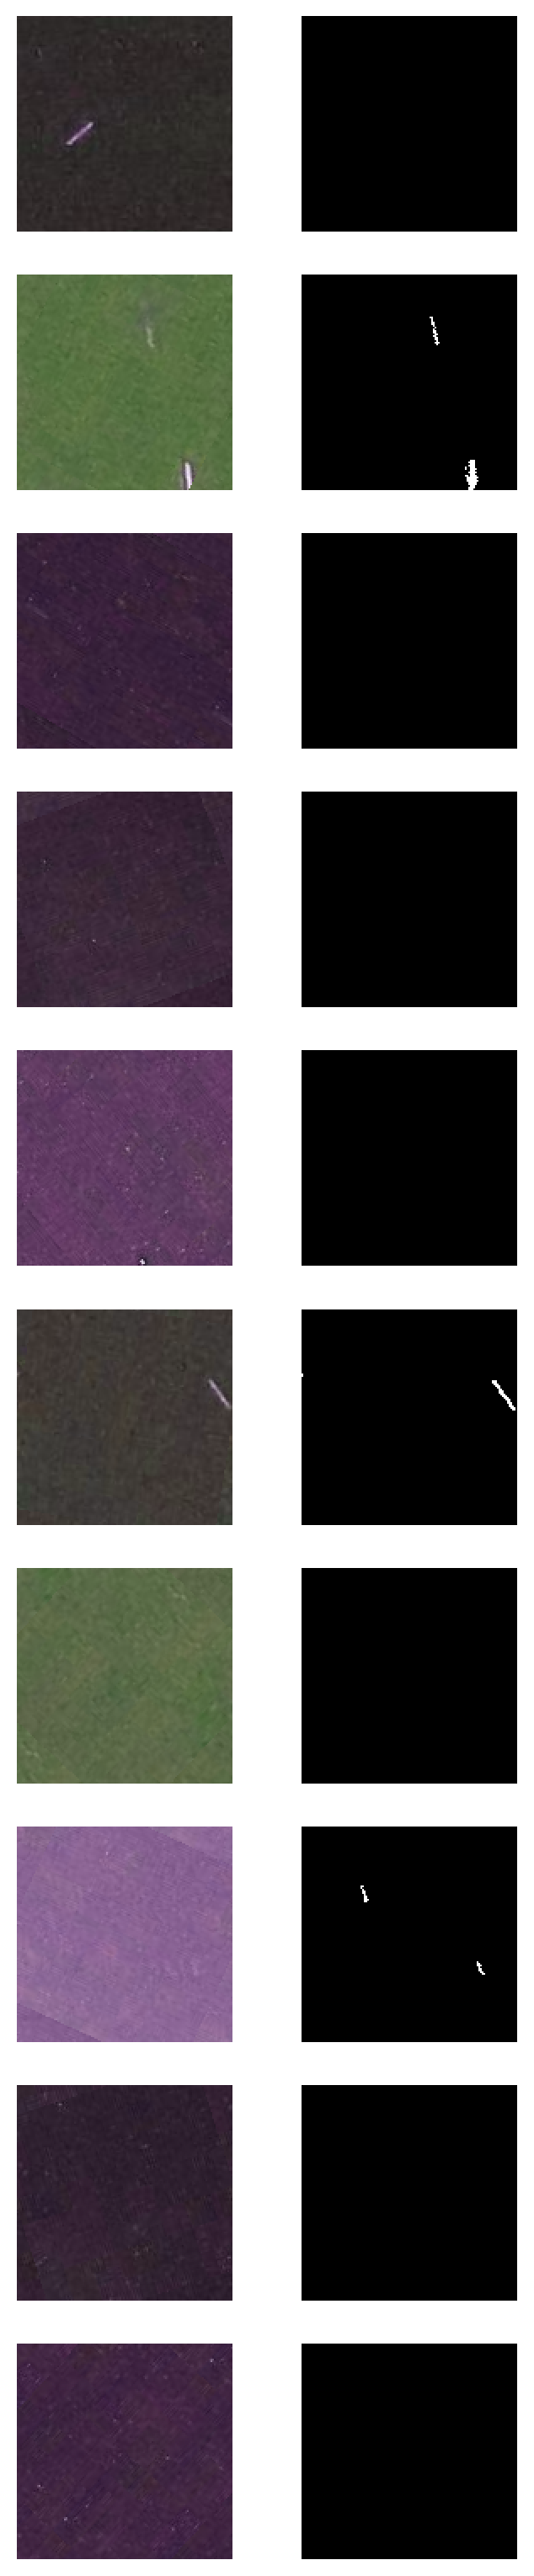

In [12]:
image_batch, mask_batch = next(iter(ds))

fig1 = plt.figure(figsize=(4,2*BATCH_SIZE))

# Preview part of the prepared dataset
for i in range(BATCH_SIZE):
    ax = plt.subplot(BATCH_SIZE, 2, 2*i+1)
    plt.imshow((image_batch[i].numpy() * 255).astype("uint8"))
    plt.axis('off')
    ax = plt.subplot(BATCH_SIZE, 2, 2*i+2)
    plt.imshow(mask_batch[i].numpy(), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

plt.show()

In [13]:
# Build the CNN model
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(12, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2D(12, 3, strides=1, activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(24, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2D(24, 3, strides=1, activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, 3, strides=1, activation='relu'),
    
    tf.keras.layers.Conv2DTranspose(24, 3, strides=1, activation='relu'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(12, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2DTranspose(12, 3, strides=1, activation='relu'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(3, 3, strides=1, activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=1, activation='relu'),
    # tf.keras.layers.Softmax(),
], name='NN_decoder')

model1.compile(loss='mean_squared_error', optimizer="adam", metrics=['accuracy'])
model1.summary()

Model: "NN_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 12)      336       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 124, 124, 12)      1308      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 24)        2616      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 58, 58, 24)        5208      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 24)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 64)        1

In [14]:
# Train
model1.fit(ds, epochs=10, verbose=1)

Epoch 1/10
305/305 [==============================] - 51s 164ms/step - loss: 0.0022 - accuracy: 0.9975
Epoch 2/10
305/305 [==============================] - 52s 172ms/step - loss: 0.0019 - accuracy: 0.9977
Epoch 3/10
305/305 [==============================] - 49s 159ms/step - loss: 0.0018 - accuracy: 0.9978
Epoch 4/10
305/305 [==============================] - 48s 158ms/step - loss: 0.0017 - accuracy: 0.9979
Epoch 5/10
305/305 [==============================] - 49s 161ms/step - loss: 0.0017 - accuracy: 0.9979
Epoch 6/10
305/305 [==============================] - 49s 159ms/step - loss: 0.0017 - accuracy: 0.9979
Epoch 7/10
305/305 [==============================] - 50s 163ms/step - loss: 0.0017 - accuracy: 0.9980
Epoch 8/10
305/305 [==============================] - 49s 160ms/step - loss: 0.0016 - accuracy: 0.9980
Epoch 9/10
305/305 [==============================] - 49s 159ms/step - loss: 0.0016 - accuracy: 0.9980
Epoch 10/10
305/305 [==============================] - 49s 159ms/step - l

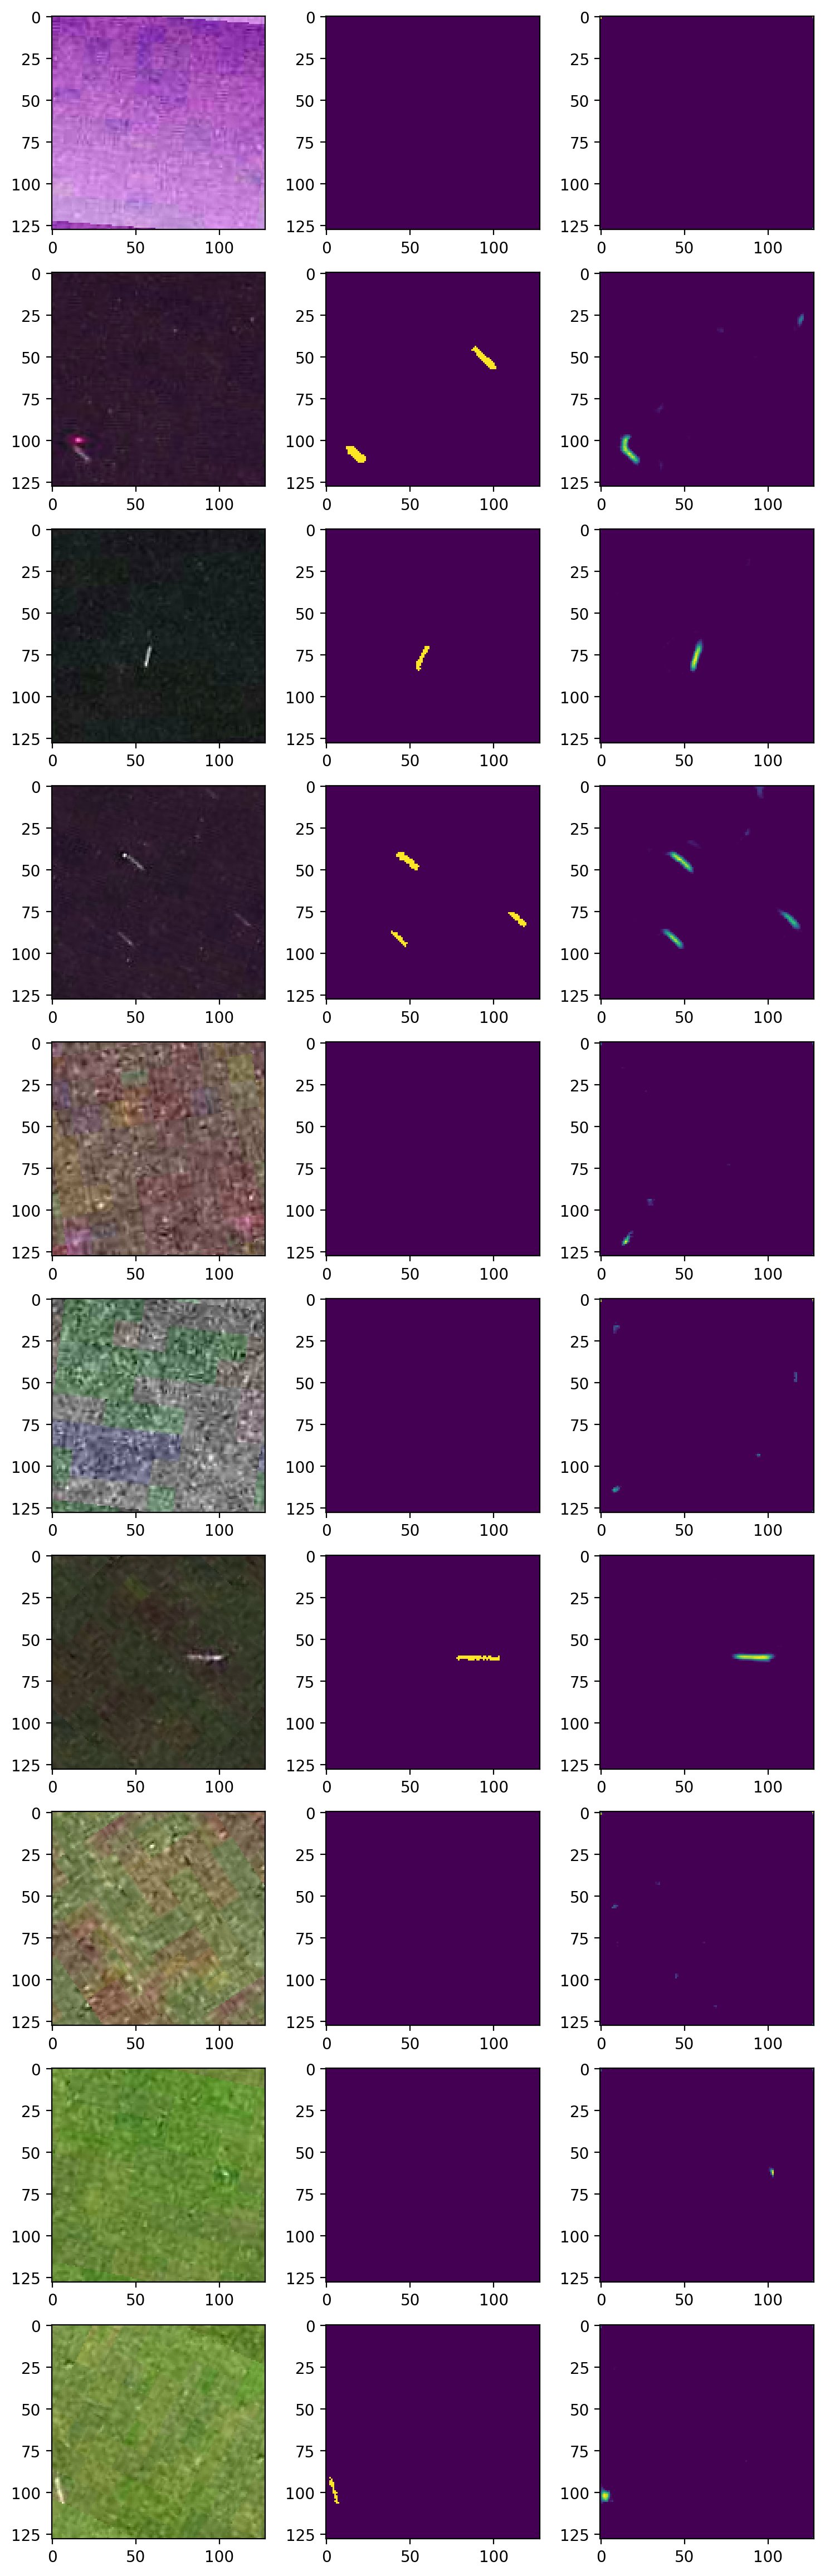

In [15]:
n = 1

# Check some of the model's results on training data
for imgbatch, maskbatch in ds.take(n):

    fig2, ax2 = plt.subplots(BATCH_SIZE, 3, figsize=(9, 3*BATCH_SIZE))
    predbatch = model1.predict(imgbatch)

    for imgtest, masktest, pred, ax in zip(imgbatch, maskbatch, predbatch, ax2) :
        ax[0].imshow(tf.keras.utils.array_to_img(imgtest))
        ax[1].imshow(tf.keras.utils.array_to_img(masktest))
        ax[2].imshow(tf.keras.utils.array_to_img(pred))
        # print(pred.max(), pred.min(), masktest.numpy().max(), masktest.numpy().min())

        # plt.close('all')

In [16]:
list_imgs2 = tf.data.Dataset.list_files('test/02_046/*', shuffle=True)

# Test
for f in list_imgs2.take(5):
  print(f.numpy())

def load_preprocess2(imgpath):
    img = tf.io.read_file(imgpath)
    img = tf.io.decode_image(img)
    img = tf.cast(img, tf.float32) / 255.0
    img.set_shape([128, 128, 3])
    return img


dstest = list_imgs.map(load_preprocess2, tf.data.AUTOTUNE)

dstest = configure_for_performance(dstest)

b'test/02_046/18_9.JPG'
b'test/02_046/25_6.JPG'
b'test/02_046/17_6.JPG'
b'test/02_046/13_12.JPG'
b'test/02_046/1_4.JPG'


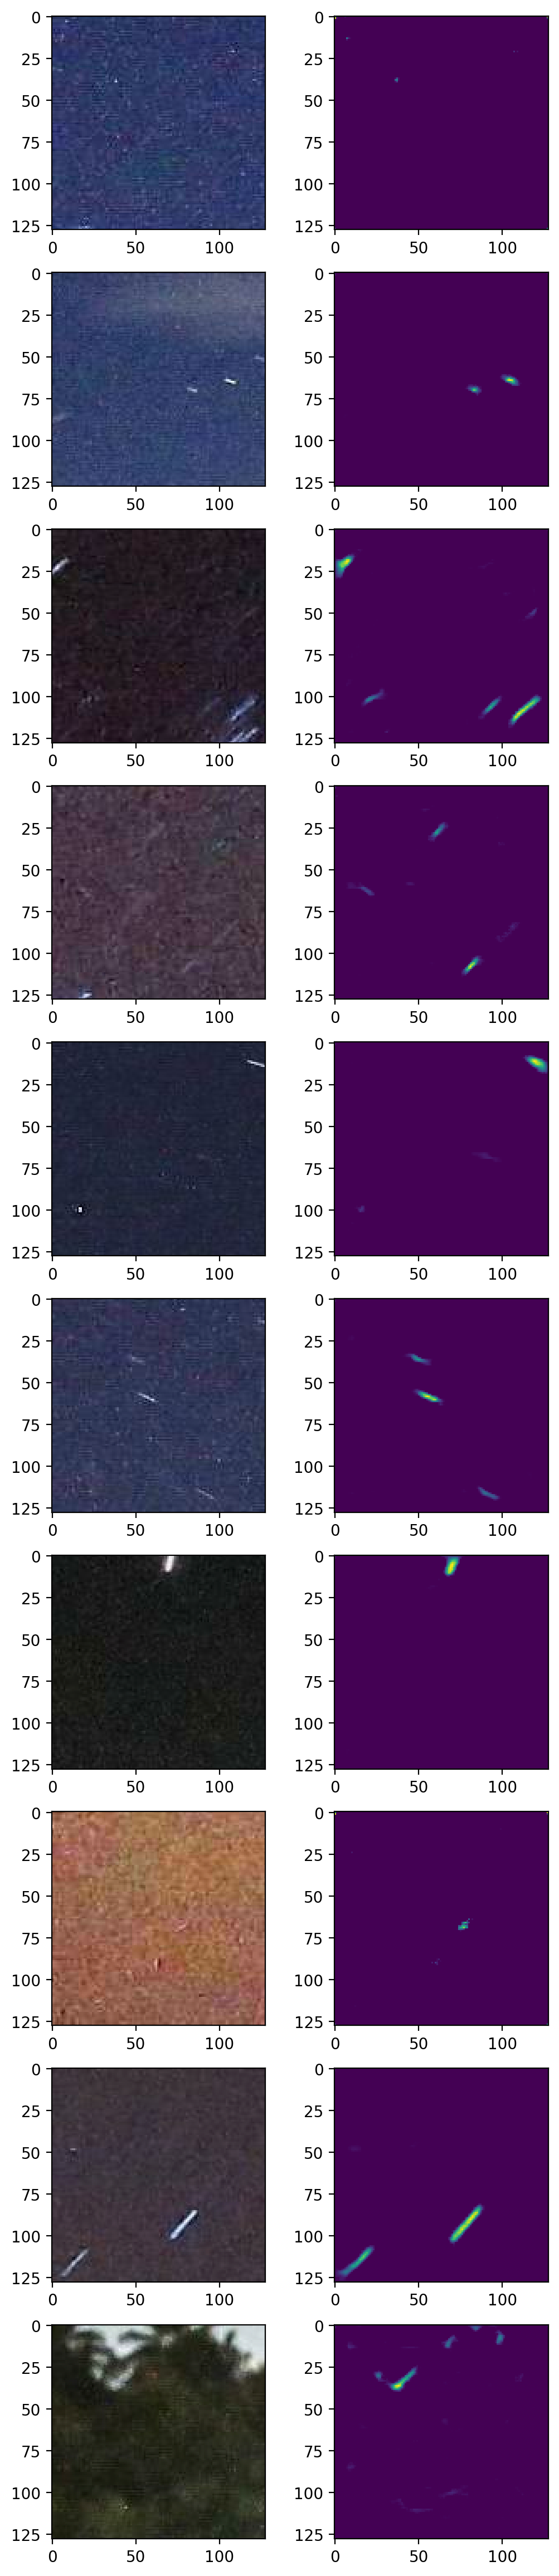

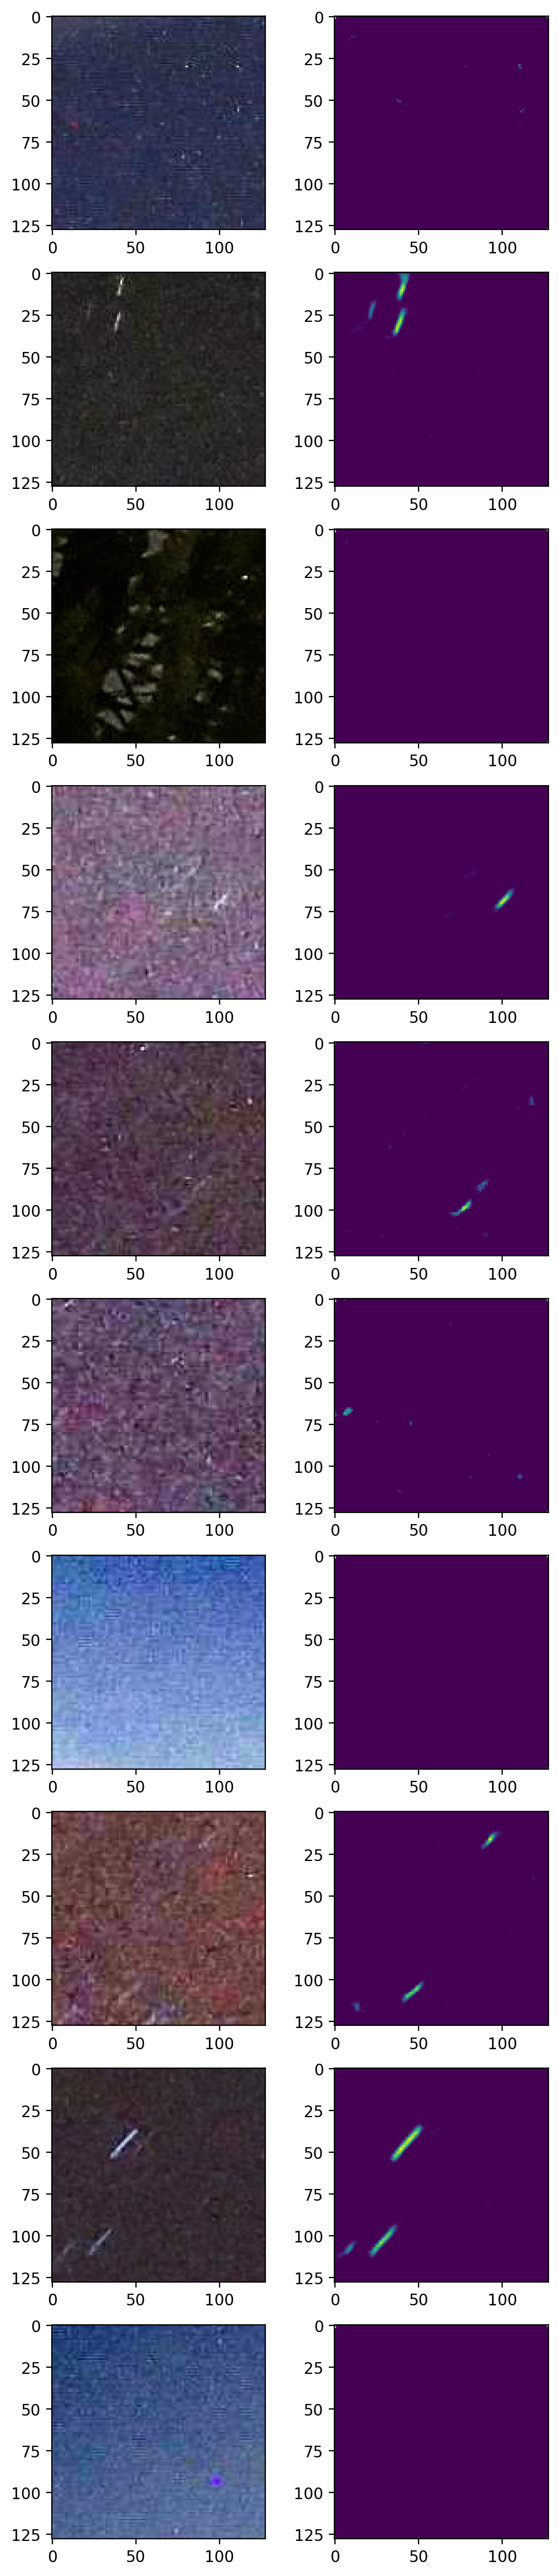

In [17]:
n = 2

for imgbatch in dstest.take(n):

    fig2, ax2 = plt.subplots(BATCH_SIZE, 2, figsize=(6, 3*BATCH_SIZE))
    predbatch = model1(imgbatch)

    for imgtest, pred, ax in zip(imgbatch, predbatch, ax2) :
        ax[0].imshow(tf.keras.utils.array_to_img(imgtest))
        ax[1].imshow(tf.keras.utils.array_to_img(pred))


In [18]:
## Save the trained weights & model to disk
model1.save('data/CNNmodel1')

INFO:tensorflow:Assets written to: data/CNNmodel1/assets
